In [1]:
import json
import torch
import gc
import matplotlib.pyplot as plt

from utils import init_sequential
from scipy.interpolate import RegularGridInterpolator as Interp2D
from pathlib import Path

import quad
from encoding import fourier_coeff, pointwise

from math import sqrt

torch.set_grad_enabled(False)

ARCH = Path('arch')
ROOT = Path('model')

FIGURES = Path('figures')
FIGURES_PRED = FIGURES / 'pred'
FIGURES_BASIS = FIGURES / 'basis'
FIGURES_KERNEL = FIGURES / 'kernel'
FIGURES_ERROR = FIGURES / 'error'
FIGURES_EIGV = FIGURES / 'eigv'

FIGURES_PRED.mkdir(exist_ok=True, parents=True)
FIGURES_BASIS.mkdir(exist_ok=True, parents=True)
FIGURES_KERNEL.mkdir(exist_ok=True, parents=True)
FIGURES_ERROR.mkdir(exist_ok=True, parents=True)
FIGURES_EIGV.mkdir(exist_ok=True, parents=True)

name = 'SS1_100'
epoch = 10000

with open(ARCH / f'{name}.json', 'r') as f:
    params = json.load(f)

PATH = ROOT / params['name']

savefig = True
MODEL_PREFIX = r'$SS^1_{\theta}$'

FIGURES_PREFIX = f'{params["name"]}_epoch{epoch}'
plt.rc('font', size=14)
plt.rc('lines', linewidth=2)

# FIGURES_PREFIX = f'{params["name"]}_epoch{epoch}_slide'
# plt.rc('font', size=16)
# plt.rc('lines', linewidth=4)

In [2]:
A = init_sequential(
    params['layers-apprx'],
    params['apprx-finish_with_activation'])
T = init_sequential(
    params['layers-trunk'],
    params['trunk-finish_with_activation'])

data = torch.load(PATH / f'{epoch}.model')

A.load_state_dict(data['A'][0])
T.load_state_dict(data['T'][0])

<All keys matched successfully>

In [3]:
match params['quad-name']:
    case 'gaussian':
        int_p, int_w, _, _ = quad.gaussian_quadrature(params['quad-size'])
    case 'trapezoidal':
        int_p, int_w, _, _ = quad.trapezoidal_rule(params['quad-size'])
    case _:
        int_p, int_w, _, _ = quad.trapezoidal_rule(params['quad-size'])

In [4]:
print(A)
print(T)

Sequential(
  (0): Linear(in_features=100, out_features=8, bias=True)
)
Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): PAU(m=5, n=4, efficient=True)
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): PAU(m=5, n=4, efficient=True)
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): PAU(m=5, n=4, efficient=True)
  (6): Linear(in_features=100, out_features=8, bias=True)
)


In [5]:
def model(xb, p):
    '''
        xb [bs]x[enc_dim]
        p  [points]x[2]
    '''
    a = A(xb)
    b = T(p.T)
    return a @ b.T

In [6]:
def compute_ticks(a): return [a.min(), a.mean(), a.max()]

/home/dasvaca/Documents/ms/operator_learning/venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/dasvaca/Documents/ms/operator_learning/venv/lib/python3.12/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


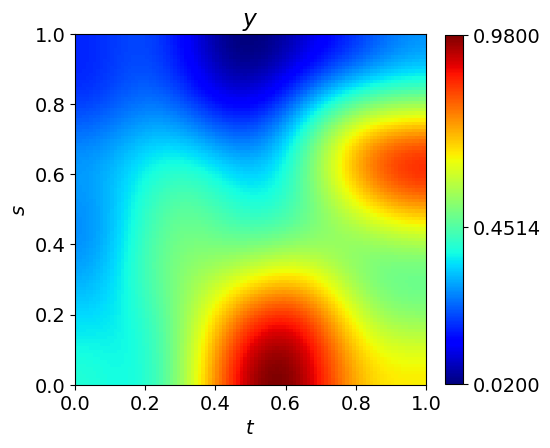

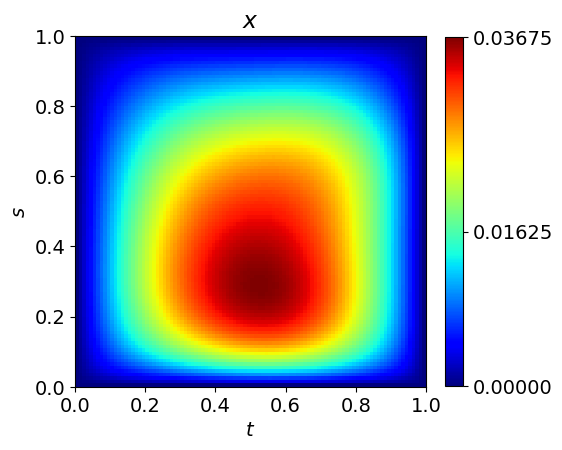

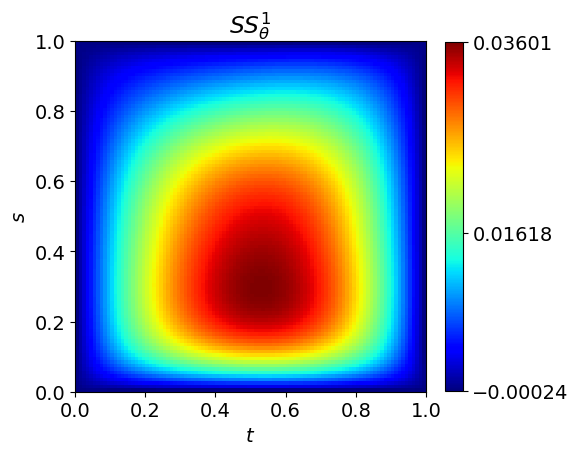

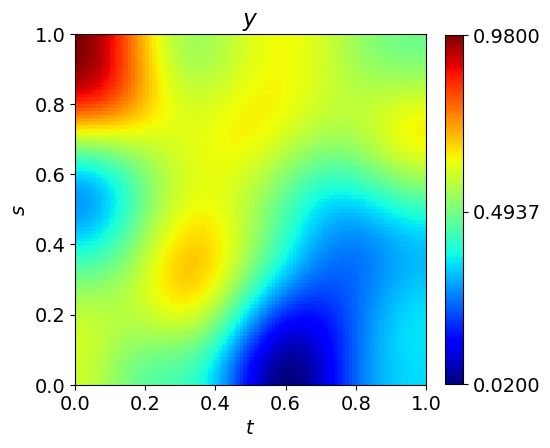

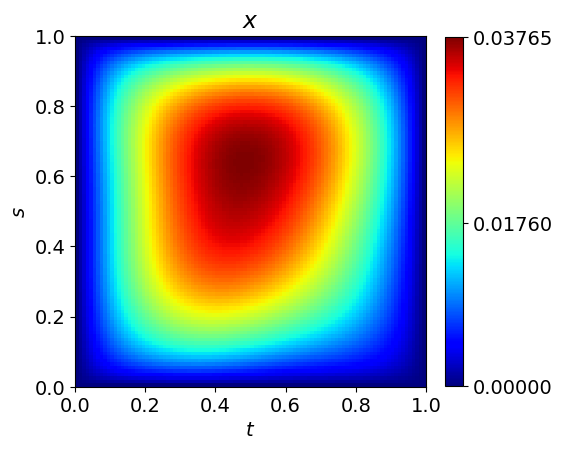

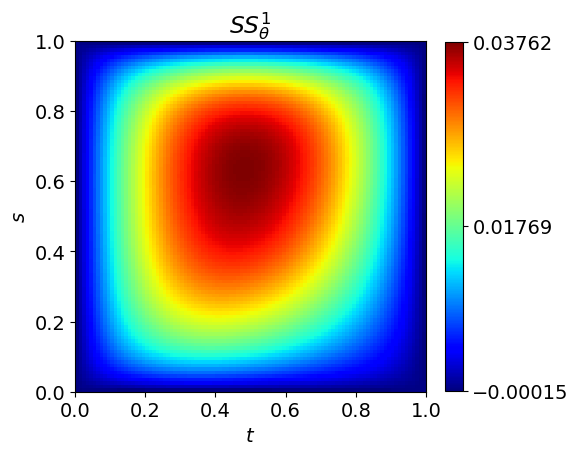

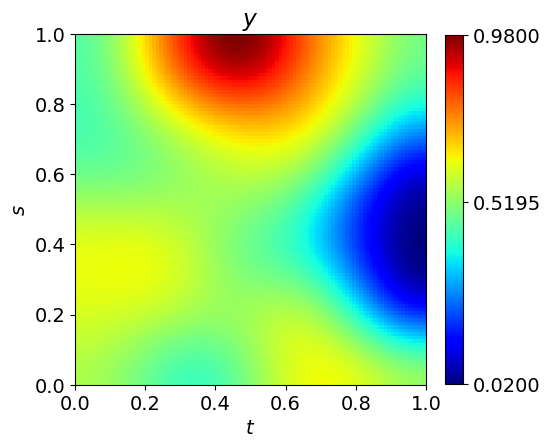

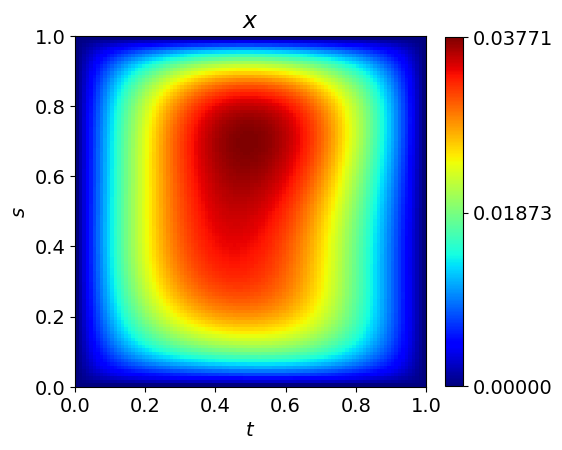

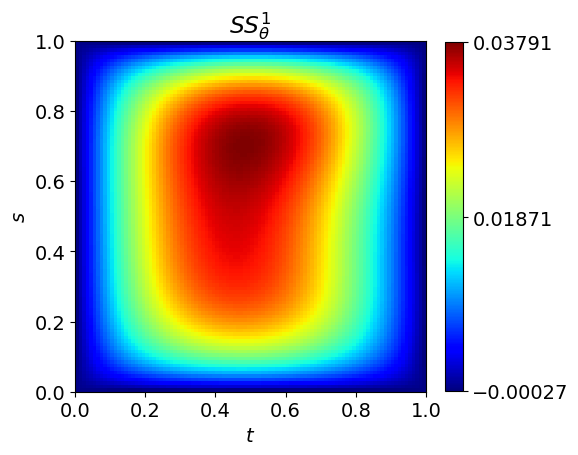

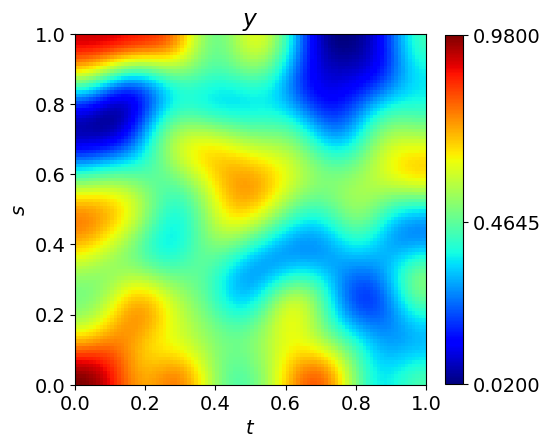

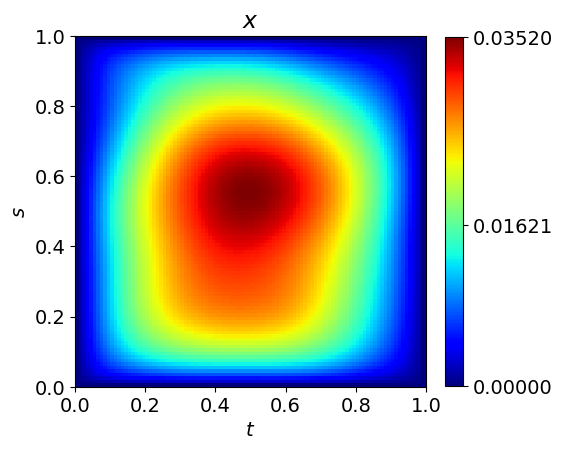

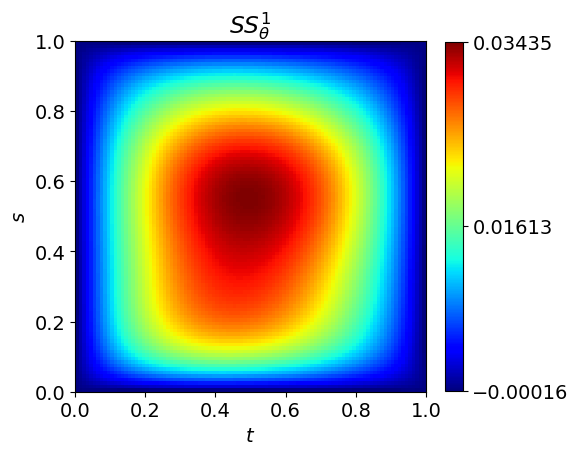

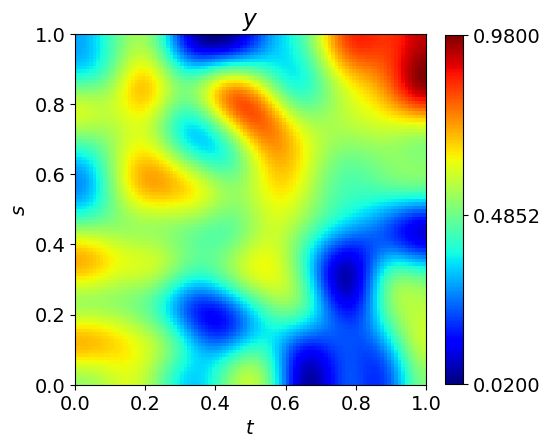

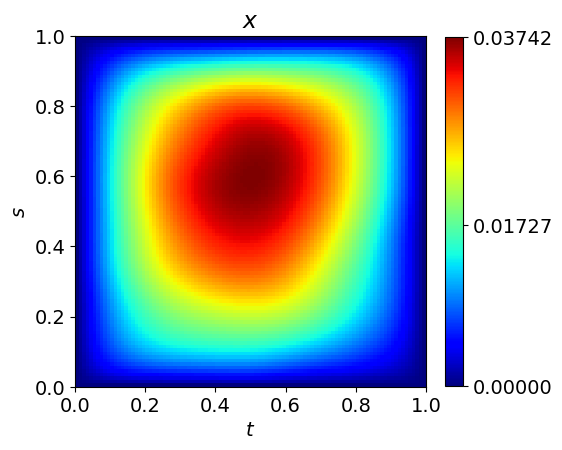

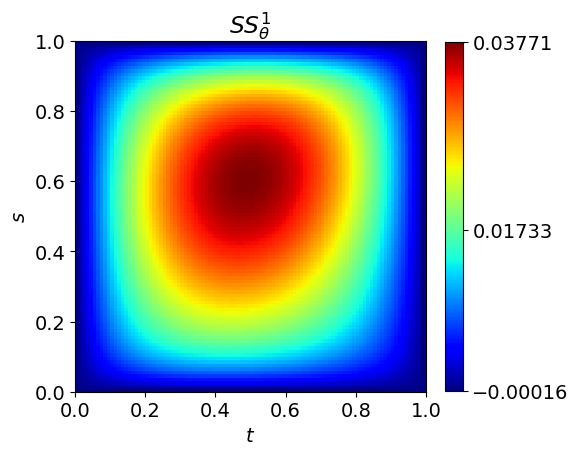

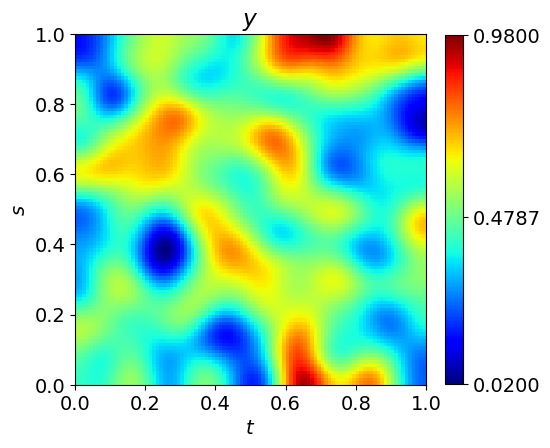

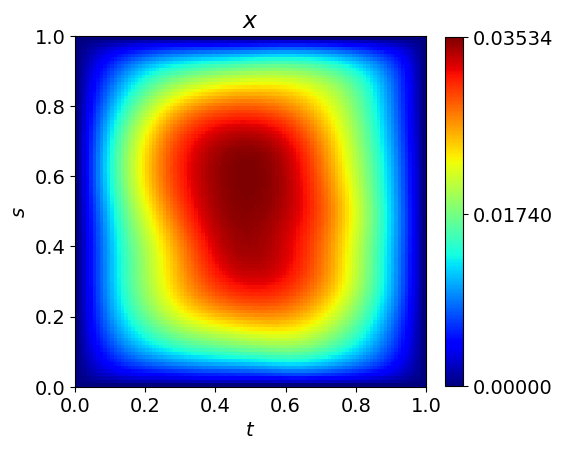

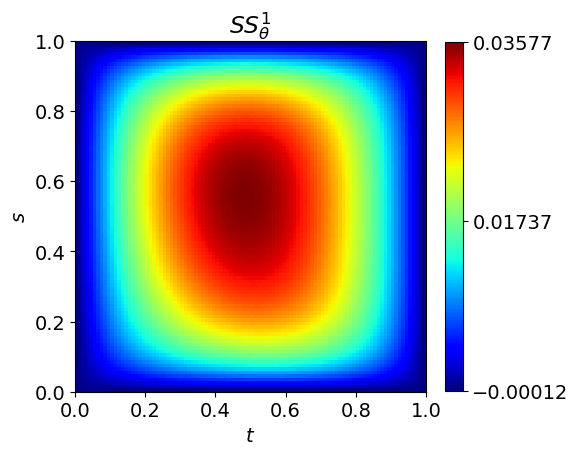

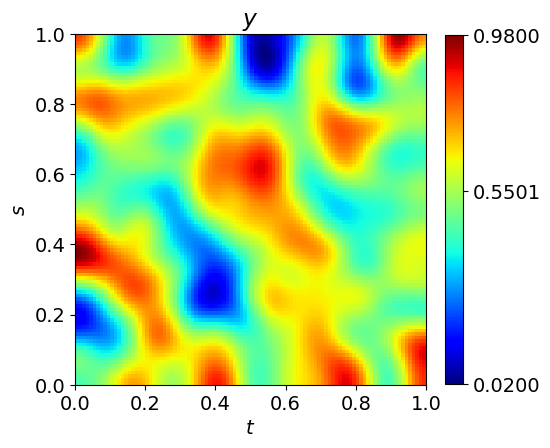

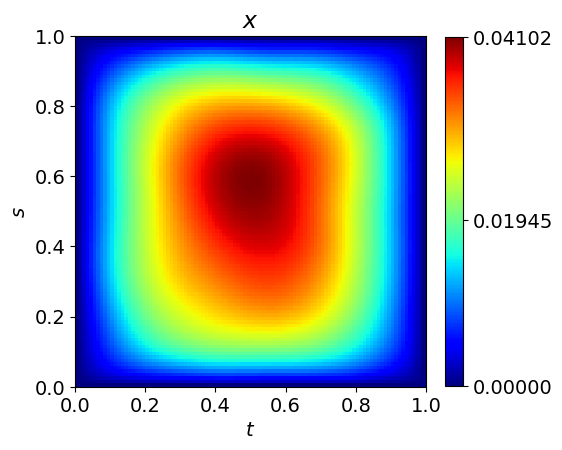

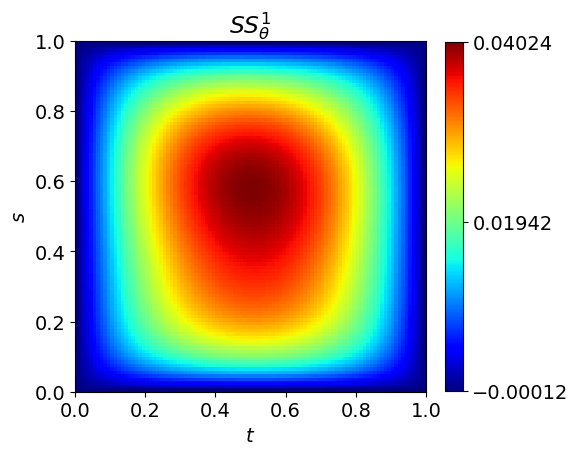

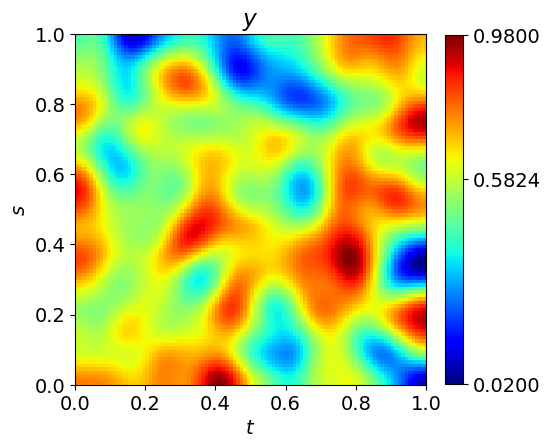

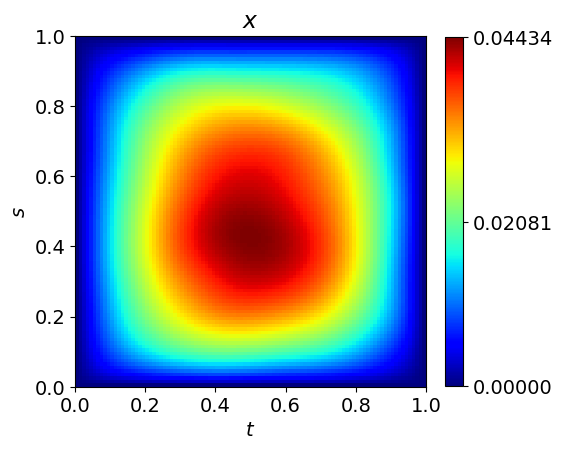

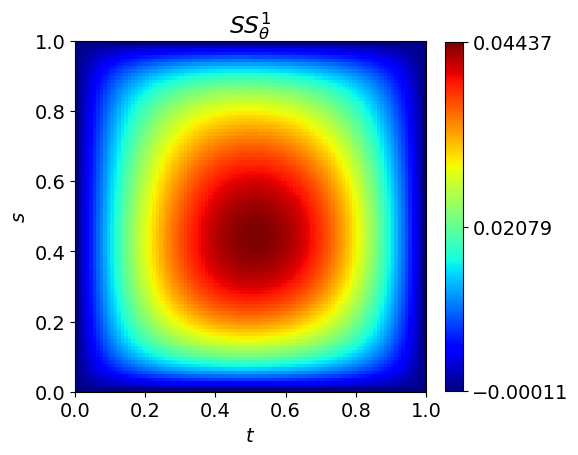

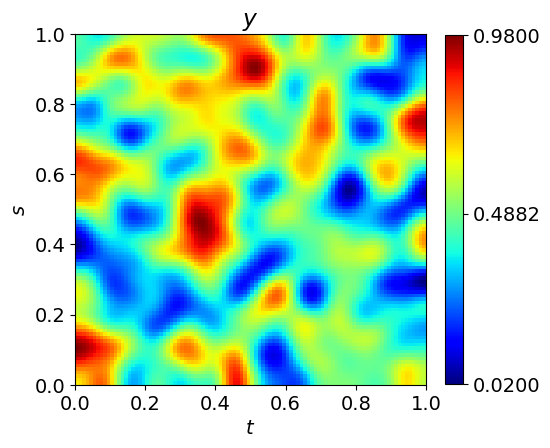

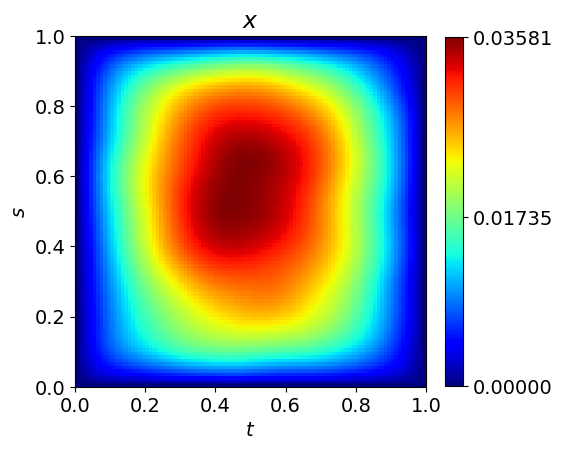

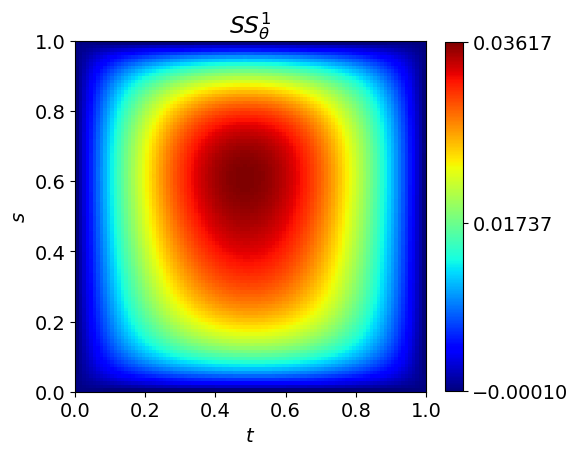

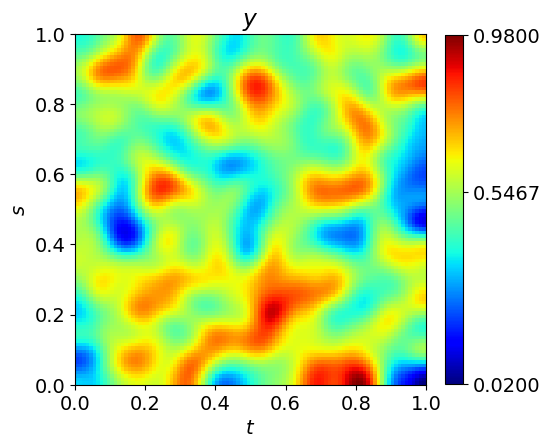

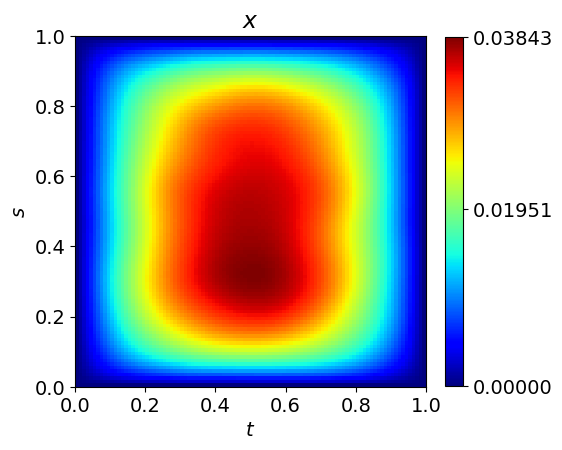

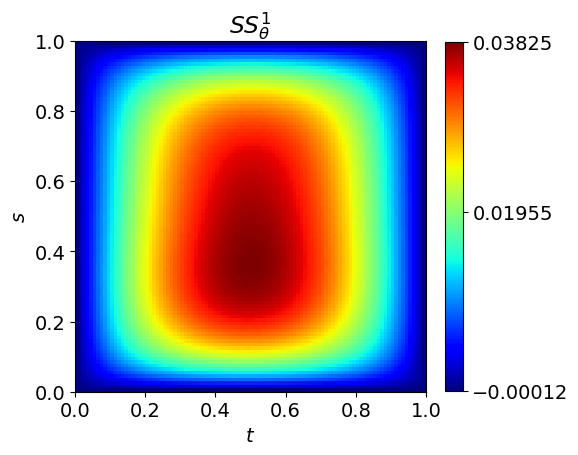

In [7]:
x_ds, y_ds = torch.load(PATH / 'valid.ds')
size = len(x_ds)
step = size // 10

N = 100
t = torch.linspace(0, 1, N)
tt = torch.stack(torch.meshgrid((t,t), indexing='xy')).reshape(2, -1)

for i, idx in enumerate(range(0, size, step)):
    Y = torch.load(f'dataset/{params["ds"]}/valid/{idx}_Y.pt')
    X = torch.load(f'dataset/{params["ds"]}/valid/{idx}_X.pt')

    ip = torch.linspace(0, 1, len(X)).numpy()
    
    x_pred = model(x_ds[idx].unsqueeze(0), tt).squeeze()
    x_pred = x_pred.reshape(N, N)

    plt.figure(figsize=(5, 5))
    plt.imshow(Y.T, cmap='jet', extent=[0, 1, 0, 1])
    plt.xlabel(r'$t$')
    plt.ylabel(r'$s$')
    plt.title(r'$y$')
    if savefig:
        plt.savefig(FIGURES_PRED / f'{FIGURES_PREFIX}_y_Fig{i}.png', bbox_inches='tight')
    
    plt.colorbar(location='right', fraction=0.045, ticks=compute_ticks(Y))
    if savefig:
        plt.savefig(FIGURES_PRED / f'{FIGURES_PREFIX}_y_Fig{i}_with_cbar.png', bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(5, 5))
    plt.imshow(X.T, cmap='jet', extent=[0, 1, 0, 1])
    plt.xlabel(r'$t$')
    plt.ylabel(r'$s$')
    plt.title(r'$x$')
    if savefig:
        plt.savefig(FIGURES_PRED / f'{FIGURES_PREFIX}_x_Fig{i}.png', bbox_inches='tight')
    
    plt.colorbar(location='right', fraction=0.045, ticks=compute_ticks(X))
    if savefig:
        plt.savefig(FIGURES_PRED / f'{FIGURES_PREFIX}_x_Fig{i}_with_cbar.png', bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(5, 5))
    plt.imshow(x_pred, cmap='jet', extent=[0, 1, 0, 1])
    plt.xlabel(r'$t$')
    plt.ylabel(r'$s$')
    plt.title(MODEL_PREFIX)
    if savefig:
        plt.savefig(FIGURES_PRED / f'{FIGURES_PREFIX}_Fig{i}.png', bbox_inches = 'tight')

    plt.colorbar(location='right', fraction=0.045, ticks=compute_ticks(x_pred))
    if savefig:
        plt.savefig(FIGURES_PRED / f'{FIGURES_PREFIX}_Fig{i}_with_cbar.png', bbox_inches='tight')
    plt.show()
    
    plt.close('all')
    gc.collect(2)

# Basis

In [8]:
match params['encoder']:
    case 'pointwise':
        encdim = params['layers-apprx'][0]
        iq = torch.linspace(0, 1, int(sqrt(encdim)))
        iq1, iq2 = torch.meshgrid(iq, iq, indexing='xy')
        q = torch.stack((iq1, iq2)).reshape(2, -1)
        def encoder(fun): return pointwise(fun, q)
    case 'fourier_coeff':
        lat_dim1, lat_dim2 = params['latdim']
        def encoder(fun): return fourier_coeff(fun, lat_dim1, lat_dim2, int_p, int_w)

In [9]:
N = 100
t = torch.linspace(0, 1, N)
tt = torch.stack(torch.meshgrid(t, t, indexing='xy')).view(2, -1)

BASIS = T(tt.T).T

def compute_EIGV(BASIS):
    EIGV = []
    for i, b in enumerate(BASIS):
        bfun = Interp2D((t.numpy(), t.numpy()), b.reshape(N, N).numpy())
        bint = torch.tensor(bfun(int_p.T.numpy()), dtype=torch.float32)
        benc = encoder(bfun)
        num = (bint * model(benc.unsqueeze(0), int_p)) @ int_w
        den = (bint * bint) @ int_w
        EIGV.append(num / den)
    
    return torch.tensor(EIGV)

EIGV = compute_EIGV(BASIS)

idx = torch.argsort(EIGV, descending=True)

EIGV = EIGV[idx]
BASIS = BASIS[idx]

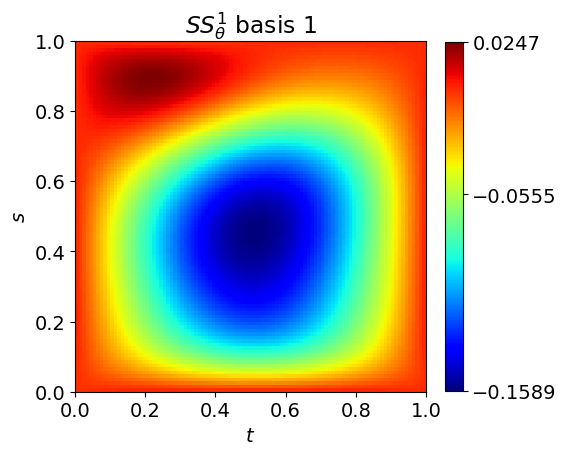

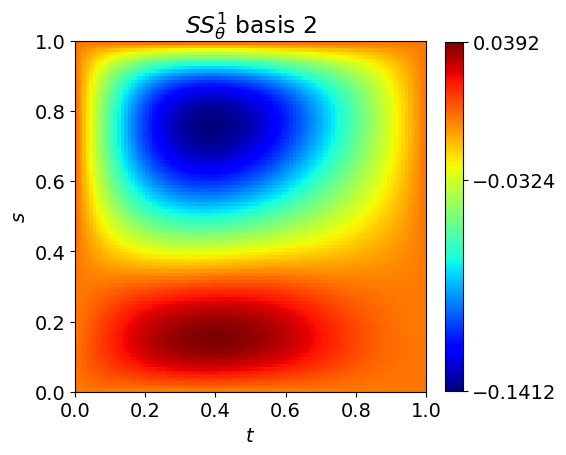

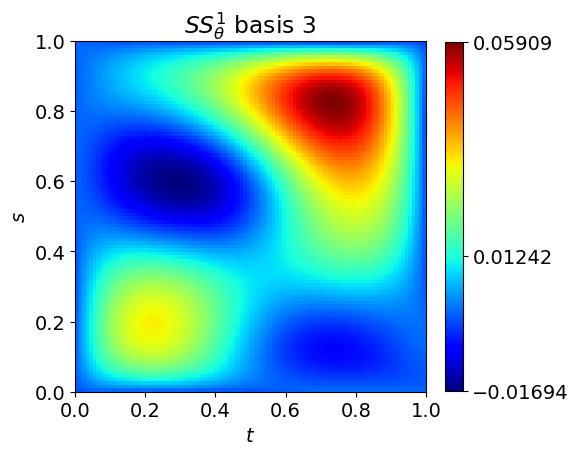

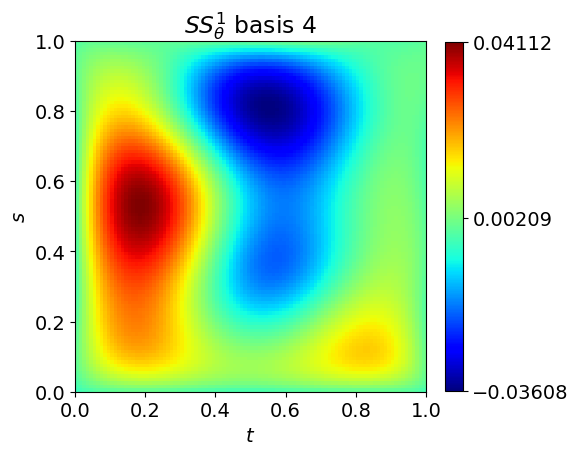

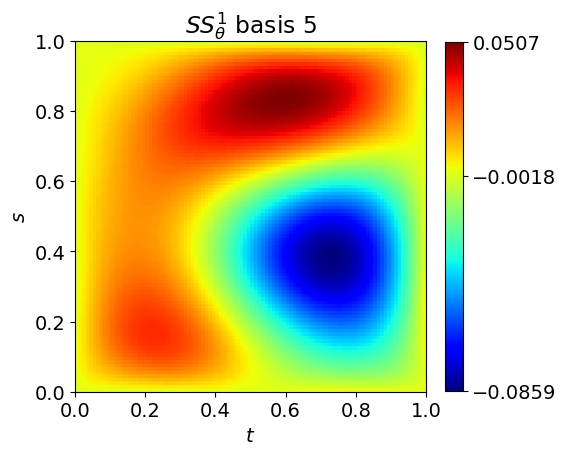

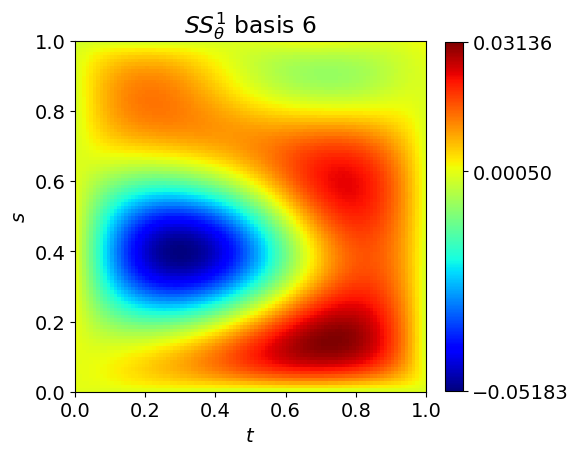

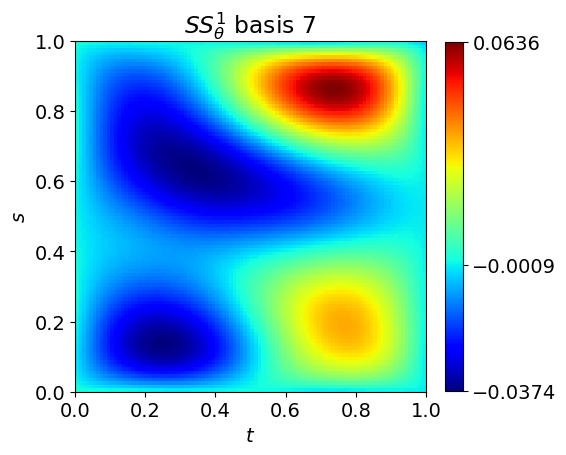

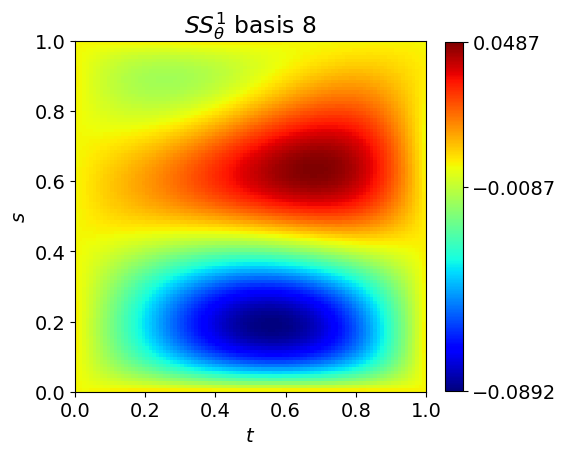

In [10]:
for i, b in enumerate(BASIS):
    plt.figure(figsize=(5, 5))
    plt.imshow(b.reshape(N, N), cmap='jet', extent=[0, 1, 0, 1])
    plt.xlabel(r'$t$')
    plt.ylabel(r'$s$')
    plt.colorbar(location='right', fraction=0.045, ticks=compute_ticks(b))
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{FIGURES_PREFIX}_Fig{i}.png', bbox_inches='tight')

    plt.title(MODEL_PREFIX + f' basis {i+1}')
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{FIGURES_PREFIX}_Fig{i}.png', bbox_inches='tight')
    plt.show()

In [11]:
#  Gram-Schmidt
V = BASIS
n = len(V)
Q = [None for _ in range(n)]
R = [[0.0 for __ in range(n)] for _ in range(n)]
_, int_w_aux, _, _ = quad.trapezoidal_rule(N)
for i in range(n):
    R[i][i] = torch.sqrt(V[i] * V[i] @ int_w_aux)
    Q[i] = V[i] / R[i][i]
    for j in range(i+1, n):
        R[i][j] = V[j] * Q[i] @ int_w_aux
        if abs(R[i][j]) >= 0.1:
            V[j] = V[j] - (Q[i] * R[i][j])
#  End Gram-Schmidt

O_BASIS = torch.stack(Q)
O_EIGV = compute_EIGV(O_BASIS)

idx = torch.argsort(O_EIGV, descending=True)

O_EIGV = O_EIGV[idx]
O_BASIS = O_BASIS[idx]

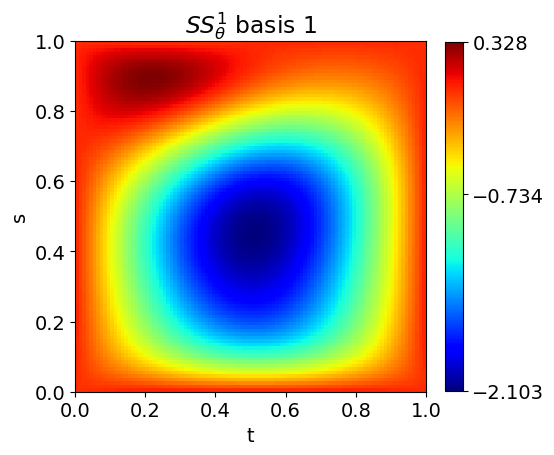

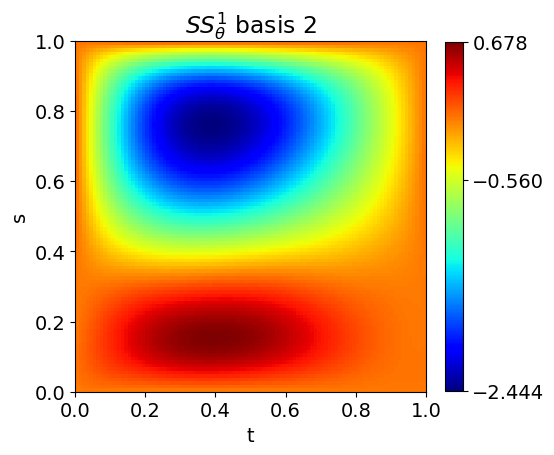

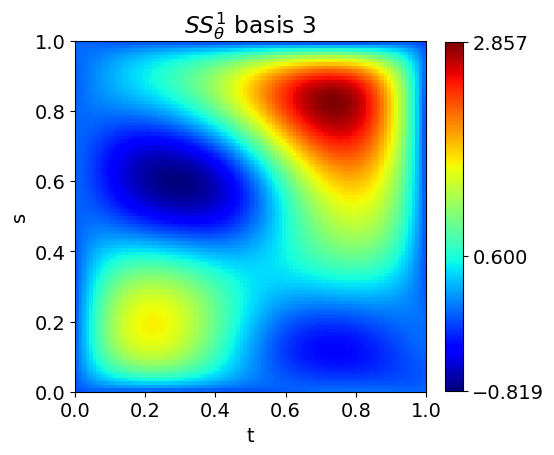

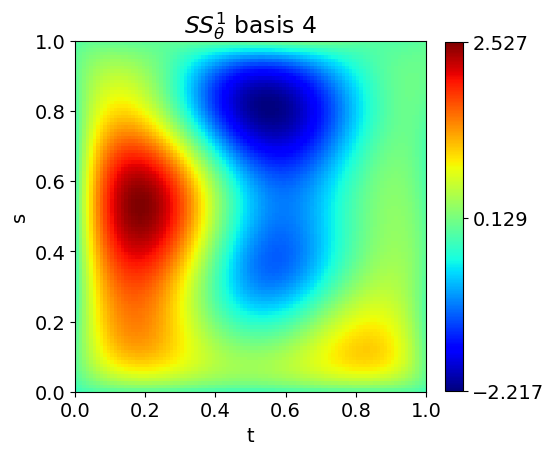

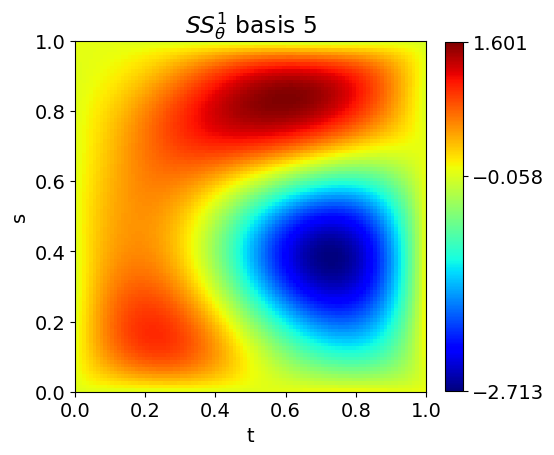

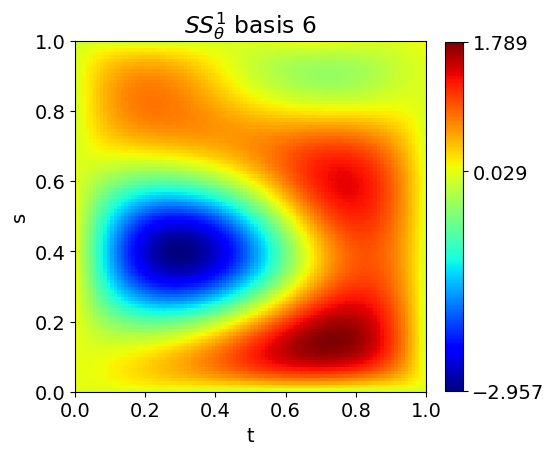

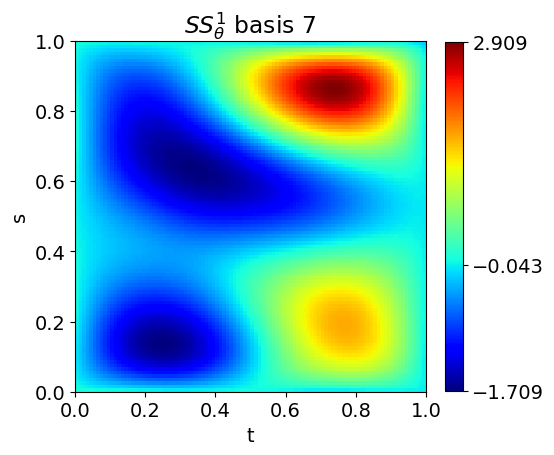

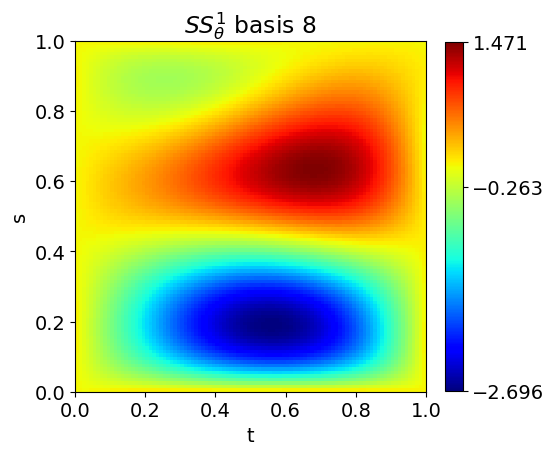

In [12]:
for i, b in enumerate(O_BASIS):
    plt.figure(figsize=(5, 5))
    plt.imshow(b.reshape(N, N), cmap='jet', extent=[0, 1, 0, 1])
    plt.xlabel('t')
    plt.ylabel('s')
    plt.colorbar(location='right', fraction=0.045, ticks=compute_ticks(b))
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{FIGURES_PREFIX}_orth_Fig{i}.png', bbox_inches='tight')
    plt.title(MODEL_PREFIX + f' basis {i+1}')
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{FIGURES_PREFIX}_orth_Fig{i}_with_title.png', bbox_inches='tight')
    plt.show()

In [13]:
Real_basis = []
Real_eigv = []

for i in range(1, 11):
    for j in range(1, 11):
        k1 = torch.tensor(i)
        k2 = torch.tensor(j)
        fun1 = torch.sin(torch.pi * k1 * tt[0])
        fun2 = torch.sin(torch.pi * k2 * tt[1])
        fun1_int = torch.sin(torch.pi * k1 * int_p[0])
        fun2_int = torch.sin(torch.pi * k1 * int_p[1])
        num = fun1 * fun2
        den = torch.sqrt((fun1_int * fun2_int)**2 @ int_w)
        Real_basis.append(num / den)
        Real_eigv.append( 1 / ((torch.pi*k1)**2 + (torch.pi*k2)**2) )

Real_basis = torch.stack(Real_basis)
Real_eigv = torch.tensor(Real_eigv)

# kernel_analytic = torch.zeros(N**2, N**2)
# for b, lmbda in zip(Real_basis, Real_eigv):
#     kernel_analytic += torch.outer(b, b) * lmbda

idx = torch.argsort(Real_eigv, descending=True)[:8]

Real_eigv = Real_eigv[idx]
Real_basis = Real_basis[idx]

# kernel_trunc = torch.zeros(N**2, N**2)
# for b, lmbda in zip(Real_basis, Real_eigv):
#     kernel_trunc += torch.outer(b, b) * lmbda

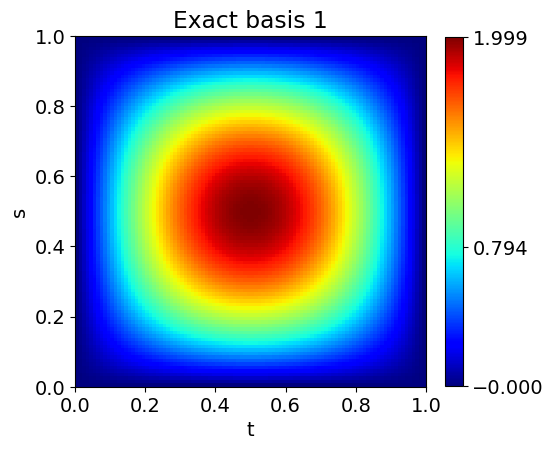

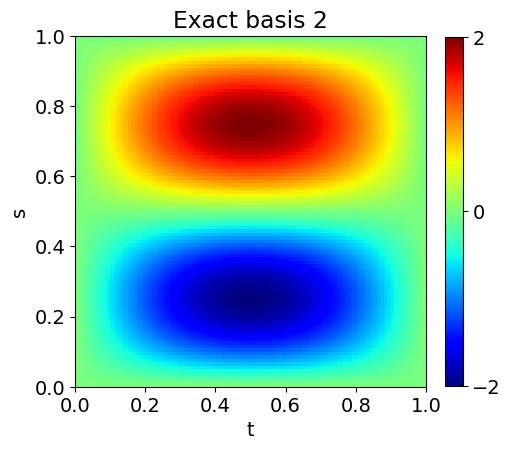

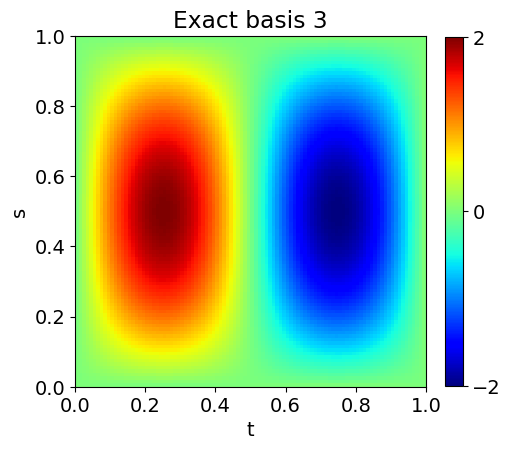

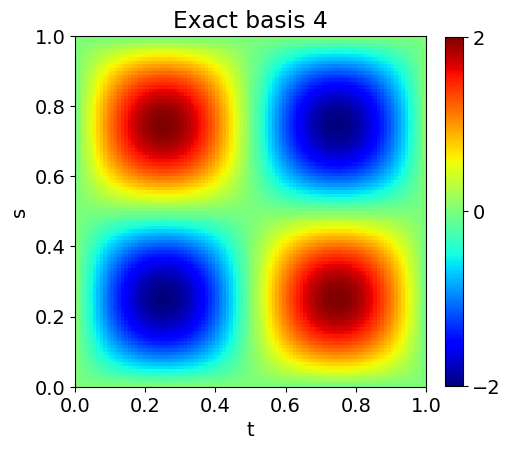

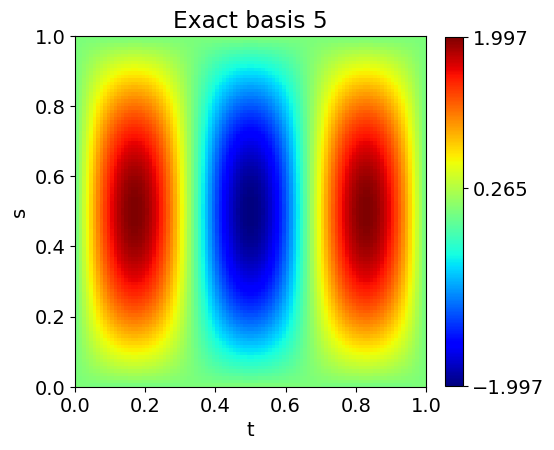

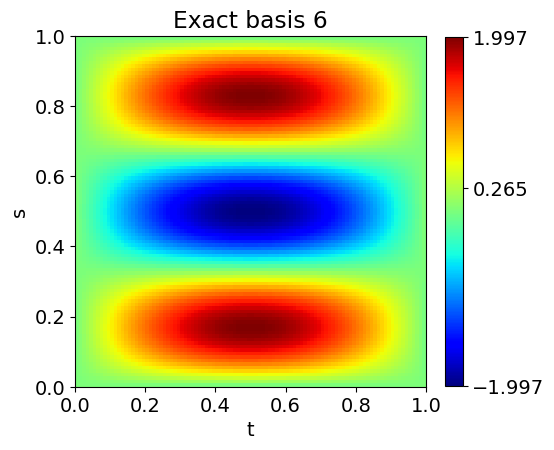

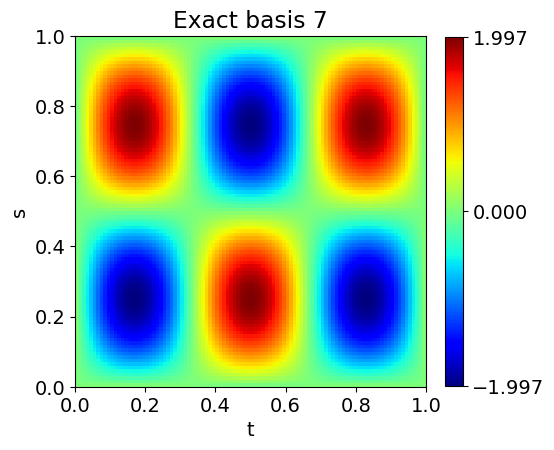

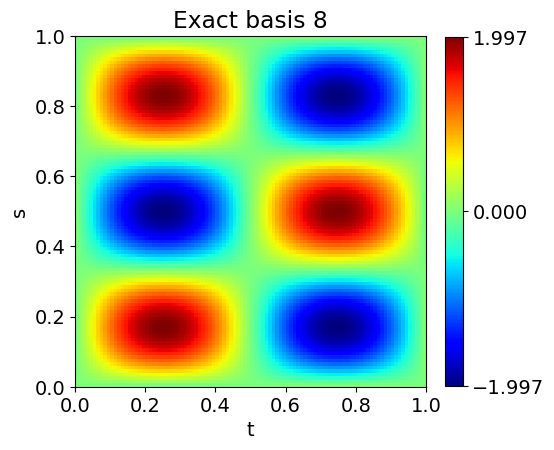

In [14]:
for i, b in enumerate(Real_basis):
    plt.figure(figsize=(5, 5))
    plt.imshow(b.reshape(N, N), cmap='jet', extent=[0, 1, 0, 1])
    plt.xlabel('t')
    plt.ylabel('s')
    plt.colorbar(location='right', fraction=0.045, ticks=compute_ticks(b))
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{FIGURES_PREFIX}_Fig{i}.png', bbox_inches='tight')

    plt.title(f'Exact basis {i+1}')
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{FIGURES_PREFIX}_Fig{i}_with_title.png', bbox_inches='tight')
    plt.show()

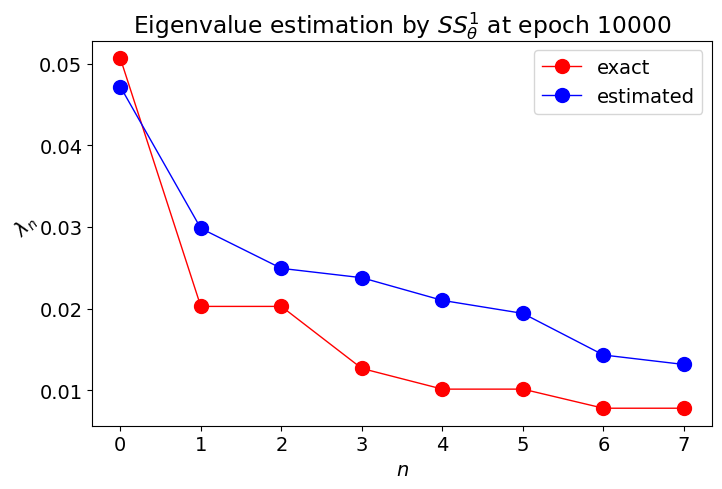

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(Real_eigv, 'or-', label='exact', markersize=10, linewidth=1)
plt.plot(EIGV, 'ob-', label='estimated', markersize=10, linewidth=1)
plt.xlabel(r'$n$')
plt.ylabel(r'$\lambda_n$', rotation=45)
plt.title(f'Eigenvalue estimation by {MODEL_PREFIX} at epoch {epoch}')
plt.legend()
if savefig:
    plt.savefig(FIGURES_EIGV / f'{FIGURES_PREFIX}_with_title.png', bbox_inches='tight')
plt.show()

# Basis2Kernel

In [16]:
kernel = torch.zeros(N**2, N**2)
for b, lmbda in zip(O_BASIS, O_EIGV):
    kernel += torch.outer(b, b) * lmbda

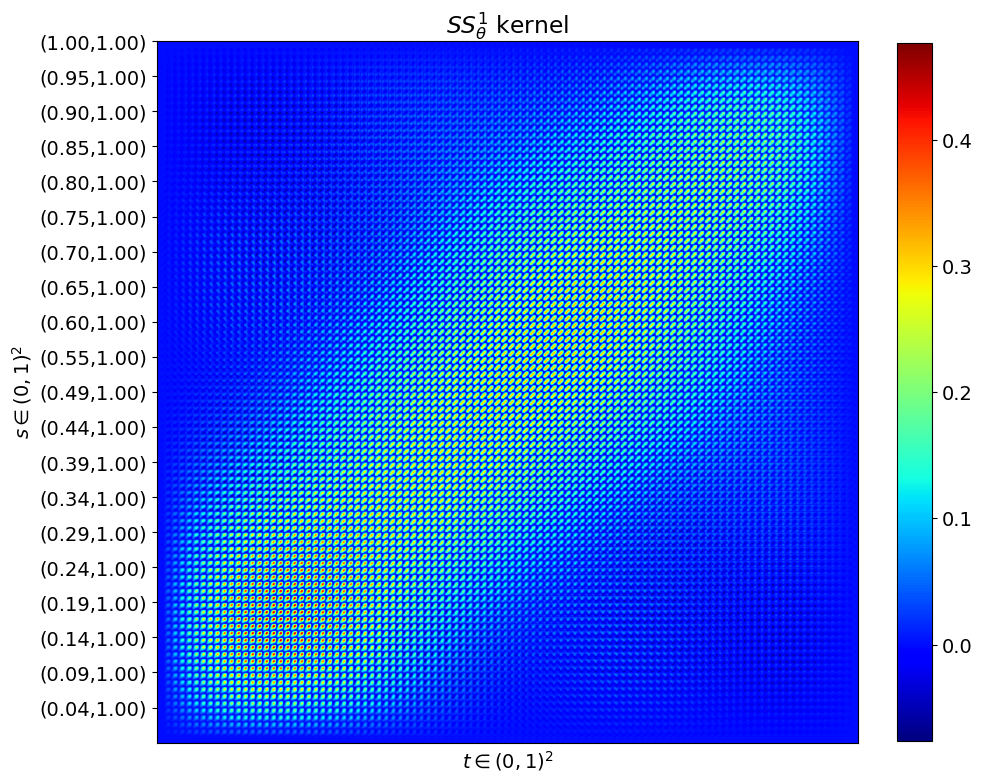

In [17]:
ticks_freq = N**2 // 20
ticks_position = [i for i in range(0, N**2, ticks_freq)]
ticks_label = []
for i in ticks_position:
    col = (i % N) + (N-1)
    row = i // N
    ticks_label.append(f'({t[len(t)-1-row]:.2f},{t[col]:.2f})')

plt.figure(figsize=(10, 10))
plt.imshow(kernel.flip(0), cmap='jet')
plt.xticks([])
plt.yticks(ticks_position, ticks_label)
plt.xlabel(r'$t\in (0,1)^2$')
plt.ylabel(r'$s\in (0,1)^2$')
plt.colorbar(location='right', fraction=0.045)
plt.title(f'{MODEL_PREFIX} kernel')
if savefig:
    plt.savefig(FIGURES_KERNEL / f'{FIGURES_PREFIX}_trunc.png', bbox_inches='tight')
plt.show()

# Errors

In [18]:
def read_error_log(logfile, rf, max_epoch=-1):
    error = []
    with open(logfile) as f:
        for line in f.readlines():
            curr_epoch, err = line.split(',')

            if max_epoch > 0 and int(curr_epoch) > max_epoch:
                break
            
            if int(curr_epoch) % rf == 0:
                error.append(float(err))

    return error

In [19]:
rf_ = 10
rf = epoch // rf_

valid_error = read_error_log(PATH / 'valid.error', rf, epoch)
train_error = read_error_log(PATH / 'train.error', rf, epoch)

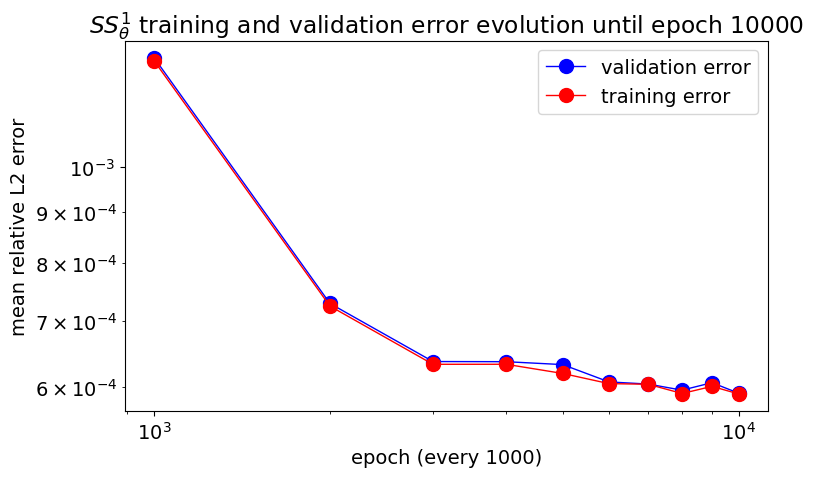

In [20]:
epoch_timeline = [k for k in range(rf, epoch+rf, rf)]

plt.figure(figsize=(8, 5))

plt.loglog(epoch_timeline, valid_error, 'ob-', label='validation error', markersize=10, linewidth=1)
plt.loglog(epoch_timeline, train_error, 'or-', label='training error', markersize=10, linewidth=1)
plt.xlabel(f'epoch (every {rf})')
plt.ylabel('mean relative L2 error')
plt.title(MODEL_PREFIX + f' training and validation error evolution until epoch {epoch}')
plt.tight_layout()
plt.legend()
if savefig:
    plt.savefig(FIGURES_ERROR / f'{FIGURES_PREFIX}_with_title.png', bbox_inches='tight')

<Figure size 800x500 with 0 Axes>

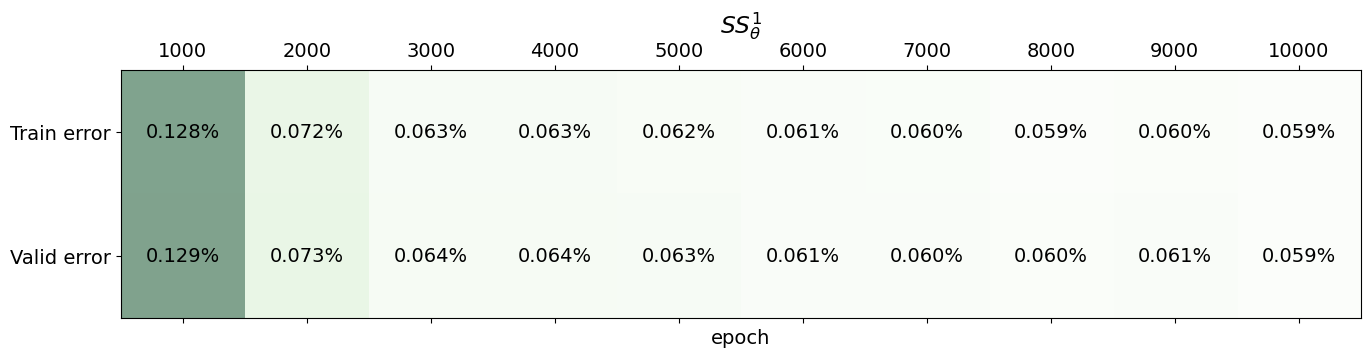

In [21]:
import numpy as np

data = np.array(list(zip(train_error, valid_error))).T

plt.figure(figsize=(8, 5))
plt.tight_layout()
plt.matshow(100 * data, cmap='Greens', alpha=0.5)
plt.xlabel('epoch')
plt.xticks(np.array(range(len(epoch_timeline))), epoch_timeline)
plt.yticks(list(range(2)), ['Train error', 'Valid error'])
plt.title(MODEL_PREFIX)

for (i, j), z in np.ndenumerate(data):
    plt.text(j, i, '{:0.3f}%'.format(100 * z), ha='center', va='center')

if savefig:
    plt.savefig(FIGURES_ERROR / f'{FIGURES_PREFIX}_table_{rf_}.png', bbox_inches='tight')
plt.show()